In [5]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
pyafar_inf_filename = '../data/AU/pyafar_infants.csv'

pyafar_inf_df = pd.read_csv(pyafar_inf_filename)

In [4]:
# Select relevant columns (imageID, Image, imageCat, and action units)
au_columns = ['Occ_au_1', 'Occ_au_2', 'Occ_au_3', 'Occ_au_4', 'Occ_au_6', 'Occ_au_9', 'Occ_au_12', 'Occ_au_20', 'Occ_au_28']
df_pyafar = pyafar_inf_df[['imageID', 'Image'] + au_columns + ['imageCat']]

# Rename the action units columns
df_pyafar = df_pyafar.rename(columns={col: f"AU{col.split('_')[-1]}" for col in au_columns})
df_pyafar = df_pyafar[['imageID', 'Image'] + [f"AU{col.split('_')[-1]}" for col in au_columns] + ['imageCat']]

df_pyafar.head()


,imageID,Image,AU1,AU2,AU3,AU4,AU6,AU9,AU12,AU20,AU28,imageCat
0,1,B1NegBW.bmp,0.582647,0.247536,0.199609,0.144951,0.749107,0.003546,0.262145,0.139866,0.054499,1
1,2,B1PosBw.bmp,0.630913,0.275316,0.029434,0.033410,0.921085,0.000916,0.968933,0.033123,0.257921,3
2,3,B2NegBw.bmp,0.501219,0.444231,0.948115,0.959741,0.999109,0.995002,0.920718,0.844951,0.002154,1
3,4,B2NeuBW.bmp,0.398275,0.739382,0.014437,0.011242,0.006104,0.000025,0.002992,0.002519,0.055800,2
4,6,B2PosBW.bmp,0.468657,0.641653,0.062889,0.042301,0.946381,0.005141,0.983136,0.750964,0.006738,3


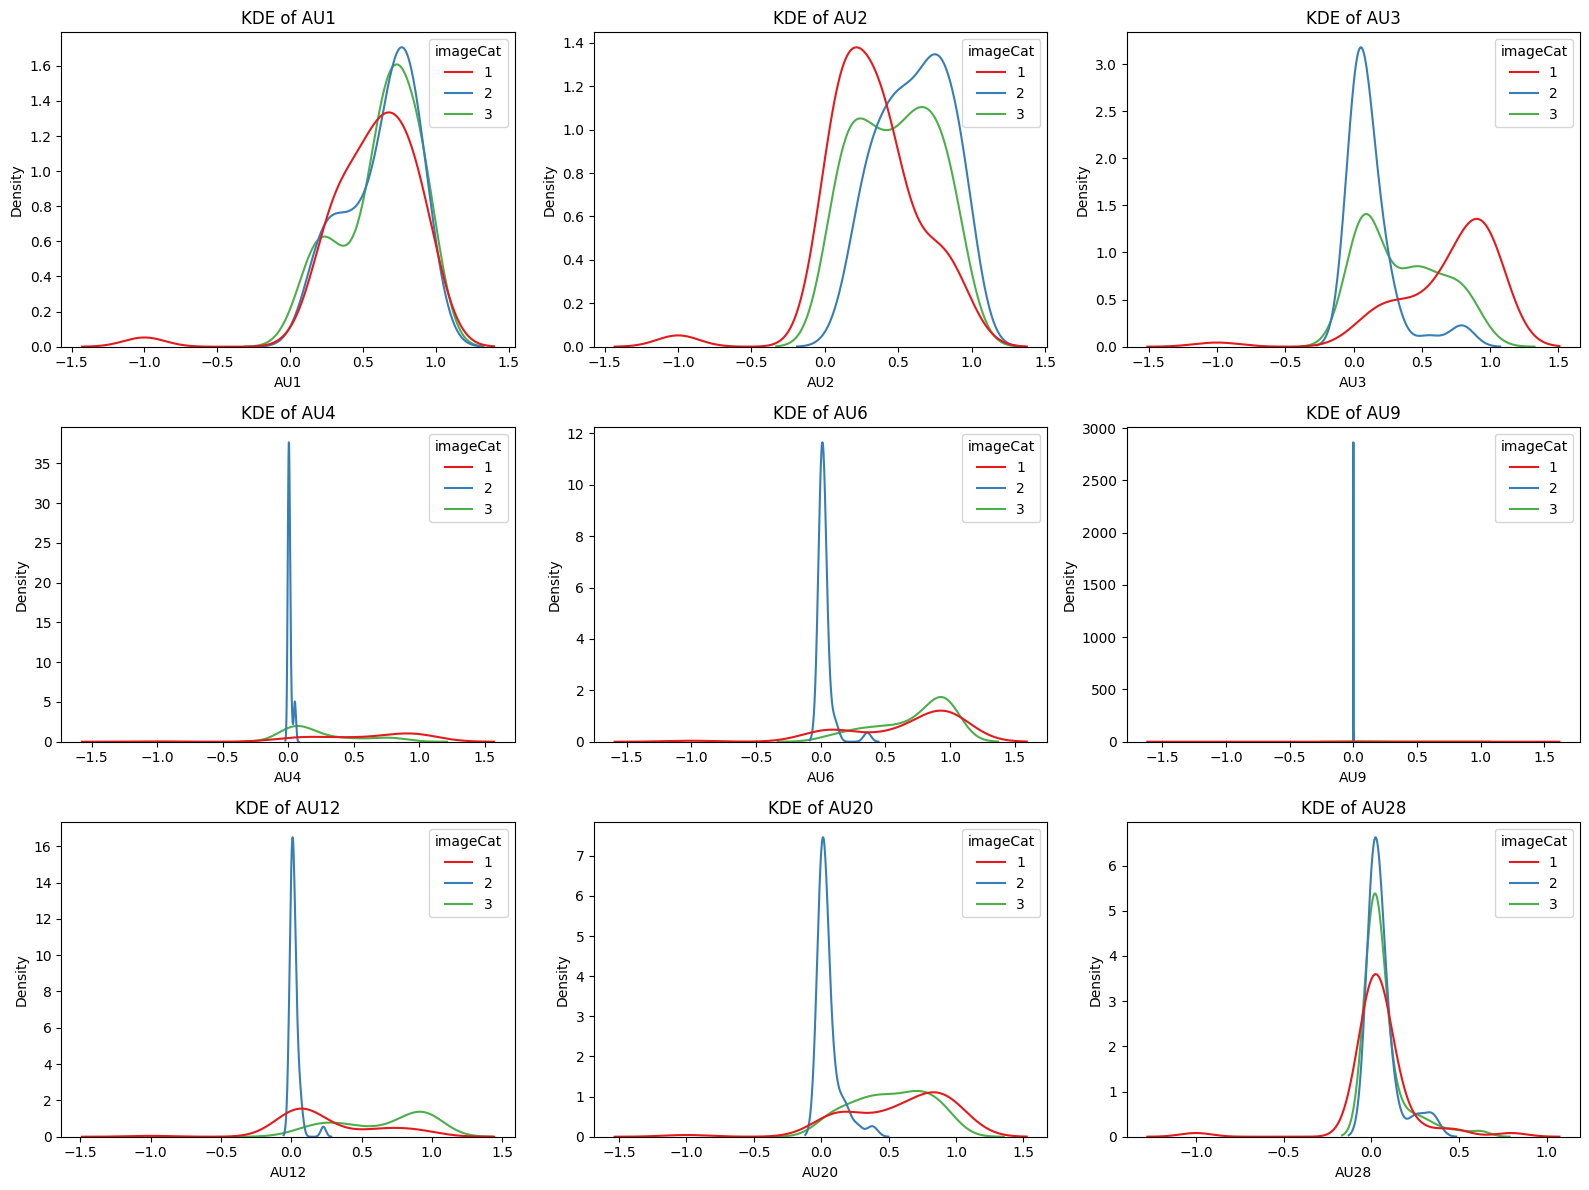

In [9]:
# List of action units
au_columns = ['AU1', 'AU2', 'AU3', 'AU4', 'AU6', 'AU9', 'AU12', 'AU20', 'AU28']

# Set up the figure with multiple subplots (one for each AU)
plt.figure(figsize=(16, 12))

for i, au in enumerate(au_columns, 1):
    plt.subplot(3, 3, i)  # Arrange the plots in a 3x3 grid
    sns.kdeplot(data=df_pyafar, x=au, hue="imageCat", fill=False, common_norm=False, palette="Set1")
    plt.title(f"KDE of {au}")
    plt.xlabel(f"{au}")
    plt.ylabel("Density")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()